## Figure 5. Expanded similarity network with additional connections to different BGC knowledgebases
This notebook integrates BiG-SCAPE network with additional information

In [81]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import scipy.spatial as spatial

from pathlib import Path
import json, shutil, yaml

In [82]:
def create_node_trace(G, node_trace_category, color, showtextlabel=False, nodesize=10, nodeopacity=0.8, 
                      nodesymbol="circle", linewidth=1, linecolor="black", textposition="top center", showlegend=False):
    if showtextlabel:
        markermode = "markers+text"
    else:
        markermode = "markers"
    nodes = np.array([node for node in G.nodes() if G.nodes[node]["node_trace"] == node_trace_category])
    pos = np.array([G.nodes[node]['pos'] for node in nodes.flatten()]).reshape(-1, 2)
    xs, ys = pos[:, 0], pos[:, 1]
    texts = np.array([G.nodes[node]['text'] for node in nodes])
    node_trace = go.Scatter(
        x=xs.tolist(),
        y=ys.tolist(),
        text=texts.tolist(),
        textposition=textposition,
        mode=markermode,
        hoverinfo='text',
        name=node_trace_category,
        showlegend=showlegend,
        marker=dict(
            symbol=nodesymbol,
            opacity=nodeopacity,
            showscale=False,
            color=color,
            size=nodesize,
            line=dict(width=linewidth, color=linecolor)))
    return node_trace

In [83]:
def create_edge_trace(Graph, name, showlegend=False, color='#888', width=0.5, opacity=0.8):
    edge_trace = go.Scatter(
        x=[],
        y=[],
        name=name,
        opacity=opacity,
        line=dict(width=width,color=color),
        hoverinfo='none',
        mode='lines',
        showlegend=showlegend)

    edges = np.array([edge for edge in Graph.edges() if G.edges[edge]["relation_type"] == name])
    pos = np.array([Graph.nodes[e]['pos'] for e in edges.flatten()]).reshape(-1, 2)
    xs = np.insert(pos[:, 0], np.arange(2, len(pos[:, 0]), 2), None)
    ys = np.insert(pos[:, 1], np.arange(2, len(pos[:, 1]), 2), None)
    edge_trace['x'] = xs
    edge_trace['y'] = ys

    return edge_trace

In [84]:
def group_markers(points, name, color="red", width=0.5, showlegend=False, fill="toself", opacity=0.8, textposition="bottom center", offset='default'):
    # Find the convex hull of the points
    hull = spatial.ConvexHull(points)

    # Get the x and y coordinates of the vertices of the hull
    x = [points[i][0] for i in hull.vertices] + [points[hull.vertices[0]][0]]
    y = [points[i][1] for i in hull.vertices] + [points[hull.vertices[0]][1]]

    # Calculate the center of the hull
    center_x = np.mean(x)
    center_y = np.mean(y)
    
    if offset == "default":
        if len(points) < 50:
            offset = len(points) * (-0.5/47) + 1.8
        else:
            offset = 1

    # Add an offset of 1 pixel to each vertex
    offset_x = [(xi - center_x) * offset + center_x for xi in x]
    offset_y = [(yi - center_y) * offset + center_y for yi in y]
    trace = go.Scatter(name=name, x=offset_x, y=offset_y, mode='lines', line=dict(width=width, color=color), 
                       showlegend=showlegend, fill=fill, opacity=opacity, textposition=textposition)
    return trace

## File Configuration

In [85]:
with open("config.yaml", "r") as f:
    notebook_configuration = yaml.safe_load(f)
notebook_configuration

{'bgcflow_dir': '/home/matin/a_drive/Saccharopolyspora',
 'project_name': 'mq_saccharopolyspora',
 'report_dir': '/home/matin/a_drive/Saccharopolyspora/data/processed/mq_saccharopolyspora',
 'antismash_version': '7.0.0'}

In [86]:
bgcflow_dir = Path(notebook_configuration["bgcflow_dir"])
project_name = "mq_saccharopolyspora"
report_dir = bgcflow_dir / f"data/processed/{project_name}"
FIGURE = "Figure_5"
FIGURE_ARTS = "Figure_4"
FIGURE_MASH = "Figure_3"
FIGURE_BIGFAM = "Figure_4"

## Setting Up Cutoff and Inputs

In [87]:
cutoff = "0.30"

In [88]:
path_bigscape = report_dir / "bigscape/for_cytoscape_antismash_6.1.1/"

In [89]:
df_bigscape = pd.read_csv([i for i in path_bigscape.glob(f"*df_network*{cutoff}*")][0])
df_bigscape_cluster = pd.read_csv([i for i in path_bigscape.glob(f"*df_cluster*{cutoff}*")][0])
df_antismash = pd.read_csv(report_dir / "tables/df_regions_antismash_6.1.1.csv")
df_bigfam = pd.read_csv(report_dir / "bigslice/query_as_6.1.1/query_network.csv")
df_arts = pd.read_csv(f"assets/tables/{FIGURE_ARTS}_df_arts_hits.csv")
df_mash = pd.read_csv(f"assets/tables/{FIGURE_MASH}b_mash_hcluster.csv", index_col=0)

In [90]:
# clean up MIBIG ids with extra .1
for i in df_bigscape.index:
    if 'BGC' in df_bigscape.loc[i, 'Clustername 1']:
        df_bigscape.loc[i, 'Clustername 1'] = df_bigscape.loc[i, 'Clustername 1'].split(".")[0]
        print(df_bigscape.loc[i, 'Clustername 1'])
    if 'BGC' in df_bigscape.loc[i, 'Clustername 2']:
        df_bigscape.loc[i, 'Clustername 2'] = df_bigscape.loc[i, 'Clustername 2'].split(".")[0]
        print(df_bigscape.loc[i, 'Clustername 2'])

for i in df_bigscape_cluster.index:
    if 'BGC' in df_bigscape_cluster.loc[i, 'bgc_id']:
        df_bigscape_cluster.loc[i, 'bgc_id'] = df_bigscape_cluster.loc[i, 'bgc_id'].split(".")[0]

BGC0001455
BGC0001455
BGC0000958
BGC0001216
BGC0000958
BGC0001455
BGC0001216
BGC0001455
BGC0001455
BGC0000055
BGC0000148
BGC0000055
BGC0000055
BGC0000055
BGC0000055
BGC0000659
BGC0000659
BGC0000659
BGC0000659
BGC0000659


In [91]:
bigfam_models_stats = pd.read_csv(f"assets/tables/{FIGURE_BIGFAM}_bigfam_models.csv", index_col=0)

## Building Edges for Networkx

In [92]:
edge_bigscape = df_bigscape.loc[:, ['Clustername 1','Clustername 2']]
edge_bigscape = edge_bigscape.rename(columns={'Clustername 1' : 'source',
                                              'Clustername 2' : 'target'})
edge_bigscape['relation_type'] = 'bigscape_similarity'
edge_bigscape['weight'] = 100

In [93]:
edge_antismash = df_antismash.loc[:, ['bgc_id', 'most_similar_known_cluster_id', 'similarity']].dropna()
edge_antismash = edge_antismash.rename(columns={'bgc_id' : 'source', 
                                                'most_similar_known_cluster_id' : 'target',
                                                'similarity' : 'value'
                                               })
edge_antismash['relation_type'] = 'antismash_knownclusterblast' 
edge_antismash['weight'] = 0.01

In [94]:
edge_arts = df_arts.loc[:, ['profile', 'bgc_id']]
edge_arts = edge_arts.rename(columns={'profile' : 'source', 
                                      'bgc_id' : 'target'})
edge_arts['relation_type'] = 'arts_hits'
edge_arts['weight'] = 1

In [95]:
edge_bigscape_class = df_bigscape_cluster.loc[:, ['bgc_id', 'bigscape_class']]
edge_bigscape_class = edge_bigscape_class.rename(columns={'bgc_id' : 'source', 
                                      'bigscape_class' : 'target'})
edge_bigscape_class['relation_type'] = 'bigscape_class'
edge_bigscape_class['weight'] = 1

In [96]:
edge_bigfam = df_bigfam[df_bigfam['rank'] == 0].loc[:, ['gcf_id', 'bgc_id']]
edge_bigfam = edge_bigfam.rename(columns={'gcf_id' : 'source', 
                                          'bgc_id' : 'target'})
edge_bigfam['relation_type'] = 'bigfam_hits'
edge_bigfam['weight'] = 1

In [97]:
for i in df_bigscape_cluster.index:
    genome_id = df_bigscape_cluster.loc[i, "genome_id"] 
    df_bigscape_cluster.loc[i, "phylogroup"] = df_mash.loc[genome_id, "phylogroup"]
edge_mash = df_bigscape_cluster.loc[:, ["bgc_id", "phylogroup"]]
edge_mash = edge_mash.rename(columns={'bgc_id' : 'source', 
                                          'phylogroup' : 'target'})
edge_mash['relation_type'] = 'phylogroup'

/tmp/ipykernel_18342/2543859903.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'P0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



## Build mapping categories

In [98]:
nodemap_antismash = df_antismash.loc[:, ['bgc_id', 'product', 'most_similar_known_cluster_description', 'similarity']].set_index('bgc_id')
nodemap_antismash['similarity'] = [f"{i:.2f}" for i in nodemap_antismash['similarity']]
nodemap_antismash = nodemap_antismash.astype(str).T.to_dict()

In [99]:
nodemap_mibig = pd.read_csv(bgcflow_dir / "resources/mibig/df_mibig_bgcs.csv", index_col=0)
nodemap_mibig = nodemap_mibig.loc[:, ["biosyn_class", "compounds"]].T.to_dict()

In [100]:
nodemap_mibig_bigscape = list(set([i for i in edge_bigscape.source if i.startswith("BGC")]).union(set([i for i in edge_bigscape.target if i.startswith("BGC")])))

In [101]:
nodemap_arts = df_arts.set_index("profile").fillna("").loc[:, ["hits_type", "function", "description"]].T.to_dict()

/tmp/ipykernel_18342/160774501.py:1: UserWarning:

DataFrame columns are not unique, some columns will be omitted.



In [102]:
nodemap_bigfam = bigfam_models_stats.loc[:, ["top_chemical_class","top_chemical_class_proportion","top_chemical_subclass","top_chemical_subclass_proportion", "H-index","richness","top_taxa","top_taxa_proportion"]]
nodemap_bigfam = nodemap_bigfam.astype(str).T.to_dict()

In [103]:
arts_map = list(df_arts.profile.unique())
bigfam_map = list(df_bigfam.astype("str").gcf_id.unique())
antismash_map = list(df_antismash.bgc_id.unique())
phylogroup_map = list(df_mash.phylogroup.unique())

## Build Network

In [104]:
df = pd.concat([edge_antismash, edge_bigscape, edge_bigfam, edge_arts])
df.to_csv(f"assets/tables/{FIGURE}_raw_network.csv")
df = df.astype(str)
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=['weight', 'relation_type', 'value'])

In [105]:
### Create groupings
# drop all ARTS
G_arts = G.copy()
for n in df_arts.profile.unique():
    try:
        G_arts.remove_node(str(n))
    except nx.NetworkXError as e:
        print(e)
    

for num, query in enumerate(nx.connected_components(G_arts)):
    for n in query:
        G.nodes[n]['group'] = num
    if len(query) > 1:
        for n in query:
            G.nodes[n]['cluster'] = True

In [106]:
nx.write_edgelist(G, f"assets/data/{FIGURE}_integrated_network_{cutoff}.graphml")

## Filtering
### Remove Unreliable BiG-FAM models
This part requires analysis from [FigS12_query_bigfam.ipynb](FigS12_query_bigfam.ipynb)

In [107]:
deleted_bigfam = []
bigfam_taxa_cutoff = 0.3
bigfam_filter = bigfam_models_stats[bigfam_models_stats.top_taxa_proportion <= bigfam_taxa_cutoff]
for n in bigfam_filter.index:
    try:
        G.remove_node(str(n))
        deleted_bigfam.append(n)  
    except nx.NetworkXError as e:
        print(e)

deleted_bigfam = ', '.join([str(i) for i in deleted_bigfam])

The node 203037 is not in the graph.
The node 208355 is not in the graph.
The node 202433 is not in the graph.
The node 225711 is not in the graph.
The node 201637 is not in the graph.
The node 202085 is not in the graph.
The node 201592 is not in the graph.
The node 218961 is not in the graph.
The node 227201 is not in the graph.
The node 200980 is not in the graph.
The node 201902 is not in the graph.


### Network Annotation

In [108]:
# define layout options
options = {
    'prog': 'neato',
    'args': ' '.join(['-Gstart=10', '-Goverlap_scaling=-100'])
#    'args': ' '.join([
#        '-Goverlap=false',
#        '-Gsplines=true',
#        '-Gnodesep=0.5',
#        '-Granksep=1'
#    ])
}

# position nodes
pos = nx.nx_agraph.graphviz_layout(G, **options)#, args='-Goverlap=false -Elen=weight')
for n, p in pos.items():
    G.nodes[n]['pos'] = p
    G.nodes[n]['text'] = n
    if n in arts_map:
        node_trace = 'ARTS model'
        G.nodes[n]['text'] = n + "<br>" + "<br>".join(nodemap_arts[n].values())
    elif n in bigfam_map:
        node_trace = 'BiG-FAM model'
        try:
            G.nodes[n]['text'] = n + "<br>" + "<br>".join(nodemap_bigfam[int(n)].values())
        except KeyError:
            print(f"Node {n} not found in bigfam_mapping")
    elif n in antismash_map:
        node_trace = "BGC"
        try:
            G.nodes[n]['text'] = n + "<br>" + "<br>".join(nodemap_antismash[n].values())
            if float(nodemap_antismash[n]['similarity']) < 0.4:
                node_trace = "BGC < 40% similarity"
            elif float(nodemap_antismash[n]['similarity']) < 0.8:
                node_trace = "BGC < 80% similarity"
            elif float(nodemap_antismash[n]['similarity']) >= 0.8:
                node_trace = "BGC >= 80% similarity"
        except TypeError as e:
            print(n, e)
    elif n.startswith("BGC"):
        node_trace = "MIBIG (KnownClusterBlast)"
        if n in nodemap_mibig_bigscape:
            node_trace = "MIBIG (BiG-SCAPE)"
        try:
            G.nodes[n]['text'] = n + "<br>" + "<br>".join(nodemap_mibig[n].values())
        except KeyError:
            pass
    if n in list(edge_mash.source):
        phylogroup = edge_mash.set_index("source").loc[n, "target"]
        G.nodes[n]['text'] = "<br>".join([phylogroup, G.nodes[n]['text']])
    G.nodes[n]['node_trace'] = node_trace

### Export positions

In [109]:
df_export_network = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
for i in df_export_network.index:
    df_export_network.loc[i, "x_pos"] = df_export_network.loc[i, "pos"][0]
    df_export_network.loc[i, "y_pos"] = df_export_network.loc[i, "pos"][1]
    df_export_network.loc[i, "cutoff"] = cutoff
df_export_network.to_csv(f"assets/tables/{FIGURE}_network_{cutoff}.csv")

/tmp/ipykernel_18342/3114959643.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



# Calculate Statistics

In [110]:
def write_stats(subgraph, condition, antismash_map):   
    number_of_bgc_nodes = [n for n in subgraph.nodes if subgraph.nodes[n]['node_trace'] == "BGC"]
    number_of_mibig_bigscape_nodes = [n for n in subgraph.nodes if subgraph.nodes[n]['node_trace'] == "MIBIG (BiG-SCAPE)"]
    number_of_mibig_knownclusterblast_nodes = [n for n in subgraph.nodes if subgraph.nodes[n]['node_trace'] == "MIBIG (KnownClusterBlast)"]
    number_of_mibig_nodes = number_of_mibig_bigscape_nodes + number_of_mibig_knownclusterblast_nodes
    connected_comp = [n for n in nx.connected_components(subgraph)]
    connected_comp_MIBIG = [n for n in connected_comp if any([x.startswith("BGC") for x in n])]
    connected_comp_MIBIG_BGC_only = [[x for x in n if subgraph.nodes[x]['node_trace'] == "BGC" ] for n in connected_comp_MIBIG]
    singleton_bgc = [n for n in connected_comp if len([x for x in n if G.nodes[x]['node_trace'] == "BGC"]) == 1]
    true_singleton_bgc = [n for n in connected_comp if len(n) == 1]

    number_of_mibig_bigscape_nodes = [n for n in subgraph.nodes if subgraph.nodes[n]['node_trace'] == "MIBIG (BiG-SCAPE)"]
    number_of_mibig_knownclusterblast_nodes = [n for n in subgraph.nodes if subgraph.nodes[n]['node_trace'] == "MIBIG (KnownClusterBlast)"]
    connected_comp = [n for n in nx.connected_components(subgraph)]
    connected_comp_MIBIG_bigscape_nodes = [n for n in connected_comp if any([x in number_of_mibig_bigscape_nodes for x in n])]
    connected_comp_MIBIG_knownclusterblast_nodes = [n for n in connected_comp if any([x in number_of_mibig_knownclusterblast_nodes for x in n])]
    connected_comp_MIBIG_knownclusterblast_nodes = [n for n in connected_comp_MIBIG_knownclusterblast_nodes if n not in connected_comp_MIBIG_bigscape_nodes]
    connected_comp_no_MIBIG = [n for n in connected_comp if not any([x.startswith("BGC") for x in n])]
    connected_comp_MIBIG_knownclusterblast_nodes_above_80 = []
    connected_comp_MIBIG_knownclusterblast_nodes_below_80 = []
    
    
    for n in connected_comp_MIBIG_knownclusterblast_nodes:
        result = []
        for x in n:
            if x in antismash_map:
                if float(nodemap_antismash[x]['similarity']) >= 0.8:
                    result.append(x)
        if len(result) > 0:
            connected_comp_MIBIG_knownclusterblast_nodes_above_80.append(n)
        else:
            connected_comp_MIBIG_knownclusterblast_nodes_below_80.append(n)
                
    GCF_summary = {"total_gcf" : len(connected_comp),
                   "total_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp]),
                   "MIBIG_bigscape_gcf" : len(connected_comp_MIBIG_bigscape_nodes), 
                   "MIBIG_bigscape_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp_MIBIG_bigscape_nodes]), 
                   "MIBIG_knownclusterblast_gcf" : len(connected_comp_MIBIG_knownclusterblast_nodes),
                   "MIBIG_knownclusterblast_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp_MIBIG_knownclusterblast_nodes]),
                   "MIBIG_knownclusterblast_above_80_gcf" : len(connected_comp_MIBIG_knownclusterblast_nodes_above_80),
                   "MIBIG_knownclusterblast_above_80_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp_MIBIG_knownclusterblast_nodes_above_80]),
                   "MIBIG_knownclusterblast_below_80_gcf" : len(connected_comp_MIBIG_knownclusterblast_nodes_below_80),
                   "MIBIG_knownclusterblast_below_80_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp_MIBIG_knownclusterblast_nodes_below_80]),
                   "unknown_gcf" : len(connected_comp_no_MIBIG),
                   "unknown_bgc" : sum([len([x for x in n if subgraph.nodes[x]['node_trace'].startswith("BGC")]) for n in connected_comp_no_MIBIG])
                 }
    
    text = f"""
In the {condition}, there are {nx.number_of_nodes(subgraph)} nodes and {nx.number_of_edges(subgraph)} edges.
From these, {len(number_of_bgc_nodes)} are BGCs, {len(number_of_mibig_bigscape_nodes)} are MIBIG entries identified with BiG-SCAPE, and {len(number_of_mibig_knownclusterblast_nodes)} are MIBIG entries identified with KnownClusterBlast.
In these network, there are {len(connected_comp)} connected components (GCFs), with {len(singleton_bgc)} singleton BGCs ({len(true_singleton_bgc)} true singletons). 
Of these, there are {sum([len(n) for n in connected_comp_MIBIG_BGC_only])} BGCs that belongs to {len(connected_comp_MIBIG)} GCFs with similariy to MIBIG nodes.

{" ; ".join([f'{k} : {v}' for k,v in GCF_summary.items()])}
    
    """
    return text

In [111]:
edges_to_keep = [e for e in G.edges if G.edges[e]['relation_type'] == 'bigscape_similarity']
subgraph = G.edge_subgraph(edges_to_keep)
condition = f"BiG-SCAPE network with ({cutoff} cutoff)"
text = write_stats(subgraph, condition, antismash_map)

outfile = f"assets/figures/{FIGURE}/{FIGURE}_text_bigscape_only_{cutoff}.txt"
Path(outfile).parent.mkdir(parents=True, exist_ok=True)
with open(outfile, "w") as f:
    f.writelines(text)
print(text)


In the BiG-SCAPE network with (0.30 cutoff), there are 730 nodes and 1217 edges.
From these, 148 are BGCs, 6 are MIBIG entries identified with BiG-SCAPE, and 0 are MIBIG entries identified with KnownClusterBlast.
In these network, there are 328 connected components (GCFs), with 61 singleton BGCs (206 true singletons). 
Of these, there are 0 BGCs that belongs to 4 GCFs with similariy to MIBIG nodes.

total_gcf : 328 ; total_bgc : 724 ; MIBIG_bigscape_gcf : 4 ; MIBIG_bigscape_bgc : 14 ; MIBIG_knownclusterblast_gcf : 0 ; MIBIG_knownclusterblast_bgc : 0 ; MIBIG_knownclusterblast_above_80_gcf : 0 ; MIBIG_knownclusterblast_above_80_bgc : 0 ; MIBIG_knownclusterblast_below_80_gcf : 0 ; MIBIG_knownclusterblast_below_80_bgc : 0 ; unknown_gcf : 324 ; unknown_bgc : 710
    
    


In [112]:
edges_to_keep = [e for e in G.edges if G.edges[e]['relation_type'] != 'arts_hits']
subgraph = G.edge_subgraph(edges_to_keep)
condition = f"integrated BiG-SCAPE network with ({cutoff} cutoff)"
text = write_stats(subgraph, condition, antismash_map)

outfile = f"assets/figures/{FIGURE}/{FIGURE}_text_bigscape_integrated_{cutoff}.txt"
Path(outfile).parent.mkdir(parents=True, exist_ok=True)
with open(outfile, "w") as f:
    f.writelines(text)
print(text)


In the integrated BiG-SCAPE network with (0.30 cutoff), there are 972 nodes and 2130 edges.
From these, 148 are BGCs, 6 are MIBIG entries identified with BiG-SCAPE, and 144 are MIBIG entries identified with KnownClusterBlast.
In these network, there are 202 connected components (GCFs), with 52 singleton BGCs (44 true singletons). 
Of these, there are 26 BGCs that belongs to 132 GCFs with similariy to MIBIG nodes.

total_gcf : 202 ; total_bgc : 724 ; MIBIG_bigscape_gcf : 4 ; MIBIG_bigscape_bgc : 29 ; MIBIG_knownclusterblast_gcf : 128 ; MIBIG_knownclusterblast_bgc : 573 ; MIBIG_knownclusterblast_above_80_gcf : 12 ; MIBIG_knownclusterblast_above_80_bgc : 105 ; MIBIG_knownclusterblast_below_80_gcf : 116 ; MIBIG_knownclusterblast_below_80_bgc : 468 ; unknown_gcf : 70 ; unknown_bgc : 122
    
    


## Define visualizations

In [113]:
edge_annotation_map = {'bigscape_similarity' : {'color':'black',
                                                'width':0.5}, 
                       'antismash_knownclusterblast': {'color':'blue', 
                                                       'width':0.5}, 
                       'arts_hits': {'color':'red', 
                                     'width':0.5}, 
                       'bigfam_hits': {'color':'orange', 
                                       'width':0.5},
                       'phylogroup' : {'color' : 'black',
                                     'width' : 0.5}}

node_annotation_map = {'ARTS model' : {'color':'red',
                                       'node_symbol' : 'star'},
                       'BiG-FAM model' : {'color':'orange',
                                          'node_symbol' : 'triangle-up'},
                       'MIBIG (KnownClusterBlast)' : {'color':'green',
                                                      'node_symbol' : 'square'},
                       'MIBIG (BiG-SCAPE)' : {'color':'green',
                                              'node_symbol' : 'square'},
                       "BGC >= 80% similarity" : {'color':'blue',
                                                  'node_symbol' : 'circle'},
                       "BGC < 80% similarity" : {'color':'#0077b6',
                                                 'node_symbol' : 'circle'},
                       "BGC < 40% similarity" : {'color':'#90e0ef',
                                                 'node_symbol' : 'circle'},
                       'BGC' : {'color':'white',
                                          'node_symbol' : 'circle'},
                       'phylogroup' : {'color' : 'black',
                                       'node_symbol' : 'star'}
                      }

## Draw Target Box

In [114]:
x, y = G.nodes['BGC0000148']['pos']
x1 = x - 200
x2 = x + 200
y1 = y - 200
y2 = y + 200

# Figure 5D

In [115]:
traces = []

In [116]:
showlegend=False
color="grey"

# drop all ARTS
G_arts = G.copy()
for n in df_arts.profile.unique():
    try:
        G_arts.remove_node(str(n))
    except nx.NetworkXError as e:
        print(e)
    

for num, query in enumerate(nx.connected_components(G_arts)):
    if len(query) > 2:
        points = []
        for n in query:
            q = G.nodes[n]['pos']
            points.append(q)
        traces.append(group_markers(points, str(num), color="blue", #color="#2a9d8f", 
                                    width=1, showlegend=showlegend, fill=None, 
                                    #offset=1.5, 
                                    opacity=0.8))

In [117]:
for e in ['bigscape_similarity', 'antismash_knownclusterblast', 'arts_hits', 'bigfam_hits']:
    edge_trace = create_edge_trace(G, e, color=edge_annotation_map[e]['color'], showlegend=True)
    traces.append(edge_trace)

for trace in ['ARTS model', 'BiG-FAM model', 'MIBIG (KnownClusterBlast)', 'MIBIG (BiG-SCAPE)', 'BGC', "BGC >= 80% similarity", "BGC < 80% similarity", "BGC < 40% similarity"]:
    nodeopacity = 0.5
    showtextlabel = False
    linecolor = "black"
    linewidth = 0.5
    textposition="top left"
    node_size = 8
    if trace.startswith("BGC") or trace.startswith("MIBIG (BiG-SCAPE)"):
        nodeopacity = 0.8
    node_trace = create_node_trace(G, trace, node_annotation_map[trace]['color'], showtextlabel=showtextlabel, 
                                   nodesymbol=node_annotation_map[trace]['node_symbol'], nodeopacity=nodeopacity, 
                                   showlegend=True, linecolor=linecolor, linewidth=linewidth, nodesize=node_size,
                                   textposition=textposition)
    traces.append(node_trace)
    

In [118]:
fig5D = go.Figure(data=traces,
                layout=go.Layout(
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='white',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    width=600, height=600)
                )

outfile = Path(f"assets/VAAM/overview_integrated_network_all_bound.html")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5d_html = fig5D.update_layout(width=600, height=600)
fig5d_html.write_html(outfile)

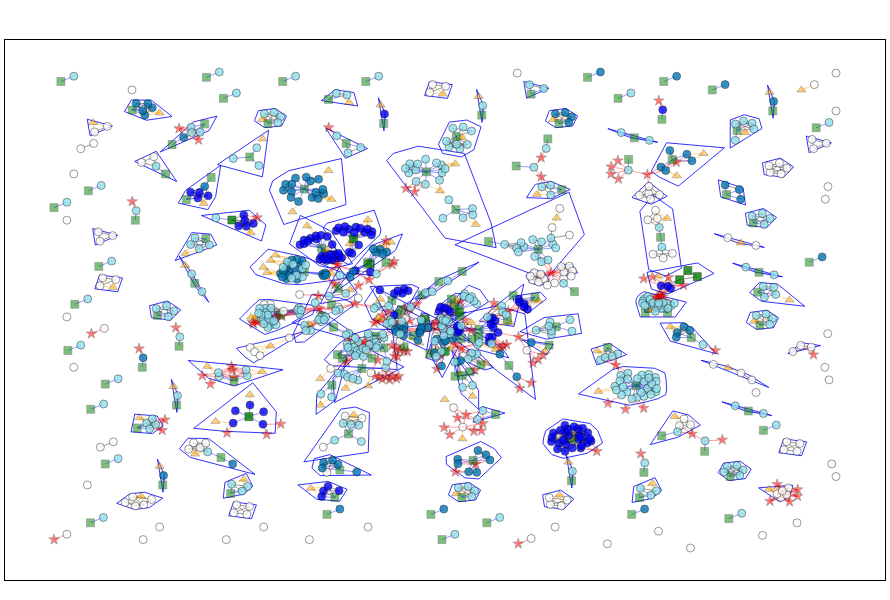

In [119]:
square = [x1, y1, x2, y2]
#fig5D.add_shape(type="rect",
#               x0=square[0], y0=square[1], x1=square[2], y1=square[3],
#               line=dict(color="Red", width=2),
#)

fig5D.update_layout(width=900, height=600,
    font=dict(
        #family="Courier New, monospace",
        size=8,  # Set the font size here
        #color="RebeccaPurple"
    )
)

In [120]:
outfile = Path(f"assets/VAAM/overview_integrated_network_all_bound.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5D.write_image(outfile)

In [121]:
fig5D.update_layout(showlegend=True)
outfile = Path(f"assets/VAAM/overview_integrated_network_all_bound_legend.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5D.write_image(outfile)

# Figure 5B

In [ ]:
traces = []

In [ ]:
for e in ['bigscape_similarity', 'arts_hits', 'bigfam_hits', "antismash_knownclusterblast"]:
    edge_trace = create_edge_trace(G, e, color=edge_annotation_map[e]['color'], showlegend=True, width=3)
    traces.append(edge_trace)

for trace in ['ARTS model', 'BiG-FAM model', 'MIBIG (KnownClusterBlast)', 'MIBIG (BiG-SCAPE)', 'BGC']:
    nodeopacity = 0.5
    showtextlabel = False
    linecolor = "black"
    linewidth = 0.5
    textposition="top left"
    node_size = 25
    if trace.startswith("BGC") or trace.startswith("MIBIG (BiG-SCAPE)"):
        nodeopacity = 0.8
    node_trace = create_node_trace(G, trace, node_annotation_map[trace]['color'], showtextlabel=showtextlabel, 
                                   nodesymbol=node_annotation_map[trace]['node_symbol'], nodeopacity=nodeopacity, 
                                   showlegend=True, linecolor=linecolor, linewidth=linewidth, nodesize=node_size,
                                   textposition=textposition)
    traces.append(node_trace)
    

In [ ]:
showlegend=False
color="grey"
for num, query in enumerate(nx.connected_components(G)):
    if len(query) > 2:
        points = []
        for n in query:
            q = G.nodes[n]['pos']
            points.append(q)
        traces.append(group_markers(points, num, color="blue", width=1, showlegend=showlegend, fill=None, opacity=0.8))

In [ ]:
fig5B = go.Figure(data=traces,
                layout=go.Layout(
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='white',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    width=600, height=600)
                )

In [ ]:
square = [x1, y1, x2, y2]

fig5B.update_layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1, range=[square[0], square[2]]),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1, range=[square[1], square[3]]))

In [ ]:
outfile = Path(f"assets/figures/{FIGURE}/{FIGURE}B_{cutoff}.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5B.write_image(outfile)

# Create a subproject for spinosyn cluster comparison

In [ ]:
query = 'BGC0000148'
neighbor = [i for i in G.neighbors(query)]
new_project_name = "spinosyn"
outfile_dir = bgcflow_dir / f"config/{new_project_name}"
outfile_dir.mkdir(parents=True, exist_ok=True)
new_project_sample = df_antismash.set_index('bgc_id', drop=False).loc[neighbor]

#.to_csv(outfile_dir / "samples.csv")

query_gbk = bgcflow_dir / f"data/external/bgc_selection/MIBIG/{query}.region001.gbk"
#! wget https://dl.secondarymetabolites.org/mibig/mibig_gbk_3.1.tar.gz -nc
#! tar -xvzf mibig_gbk_3.1.tar.gz mibig_gbk_3.1/BGC0000148.gbk
query_gbk.parent.mkdir(parents=True, exist_ok=True)
! wget -O {query_gbk} https://mibig.secondarymetabolites.org/repository/BGC0000148/generated/BGC0000148.gbk
#shutil.copy("mibig_gbk_3.1/BGC0000148.gbk", Path("../../../../") / query_gbk)
assert query_gbk.is_file()

index_col = len(new_project_sample)
new_project_sample.loc[index_col, "genome_id"] = "GCF_000062885.1"
new_project_sample.loc[index_col, "bgc_id"] = query
new_project_sample.loc[index_col, "source"] = "bgcflow"
new_project_sample.loc[index_col, "gbk_path"] = query_gbk.resolve()
new_project_sample.to_csv(outfile_dir / "samples.csv", index=False)


project_config = {'name': 'Spinosyn',
                  'schema': 'BGC',
                  'pep_version': '2.1.0',
                  'description': "A selection of putative Spynosin (BGC0000148) BGCs from mq_saccharopolyspora",
                  'sample_table': 'samples.csv',
                  'gtdb-tax': 'gtdbtk.bac120.summary.tsv',
                  'rules' : {'bigslice': False,
                             'bigscape': False,
                             'query-bigslice': False,
                             'clinker': True,
                             'mmseqs2': True,
                             'interproscan': False}
                 }

source = bgcflow_dir / "config/mq_saccharopolyspora/gtdbtk.bac120.summary.tsv"
destination = outfile_dir / source.name
shutil.copy(source, destination)

with open(outfile_dir / "project_config.yaml", "w") as f:
    json.dump(project_config, f, indent=2)

# Figure 5C

In [ ]:
traces = []

In [ ]:
for e in ['bigscape_similarity']:
    edge_trace = create_edge_trace(G, e, color=edge_annotation_map[e]['color'], showlegend=True)
    traces.append(edge_trace)

for trace in ['MIBIG (BiG-SCAPE)', 'BGC']:
    nodeopacity = 0.5
    showtextlabel = False
    linecolor = "black"
    linewidth = 0.5
    textposition="top left"
    node_size = 8
    if trace.startswith("BGC") or trace.startswith("MIBIG (BiG-SCAPE)"):
        nodeopacity = 0.8
    node_trace = create_node_trace(G, trace, node_annotation_map[trace]['color'], showtextlabel=showtextlabel, 
                                   nodesymbol=node_annotation_map[trace]['node_symbol'], nodeopacity=nodeopacity, 
                                   showlegend=True, linecolor=linecolor, linewidth=linewidth, nodesize=node_size,
                                   textposition=textposition)
    traces.append(node_trace)
    

In [ ]:
for group in df_bigscape_cluster[f'fam_known_compounds_{cutoff}'].unique():
    query = list(df_bigscape_cluster[df_bigscape_cluster[f'fam_known_compounds_{cutoff}'] == group].bgc_id)
    if len(query) > 2:
        points = []
        for n in query:
            q = G.nodes[n]['pos']
            points.append(q)
        if str(group).startswith("u"):
            showlegend=False
            color="blue"
        else:
            showlegend=False
            color="blue"
        traces.append(group_markers(points, str(group), color=color, width=1, showlegend=showlegend, fill=None))

In [ ]:
fig5C = go.Figure(data=traces,
                layout=go.Layout(
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='white',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    width=600, height=600)
                )

In [ ]:
square = [x1, y1, x2, y2]
fig5C.add_shape(type="rect",
               x0=square[0], y0=square[1], x1=square[2], y1=square[3],
               line=dict(color="Red", width=2),
)

fig5C.update_layout(
    font=dict(
        #family="Courier New, monospace",
        size=8,  # Set the font size here
        #color="RebeccaPurple"
    )
)

In [ ]:
outfile = Path(f"assets/figures/{FIGURE}/{FIGURE}C_{cutoff}.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5C.write_image(outfile)

# Figure 5A

In [ ]:
traces = []

for group in df_bigscape_cluster[f'fam_known_compounds_{cutoff}'].unique():
    query = list(df_bigscape_cluster[df_bigscape_cluster[f'fam_known_compounds_{cutoff}'] == group].bgc_id)
    if len(query) > 2:
        points = []
        for n in query:
            q = G.nodes[n]['pos']
            points.append(q)
        if str(group).startswith("u"):
            showlegend=False
            color="blue"
        else:
            showlegend=False
            color="blue"
        traces.append(group_markers(points, str(group), color=color, width=1, showlegend=showlegend, fill=None))

for e in ['bigscape_similarity']:
    edge_trace = create_edge_trace(G, e, color=edge_annotation_map[e]['color'], width=3, showlegend=True)
    traces.append(edge_trace)

for trace in ['MIBIG (BiG-SCAPE)', 'BGC']:
    nodeopacity = 0.5
    showtextlabel = False
    linecolor = "black"
    linewidth = 0.5
    textposition="top left"
    node_size = 25
    if trace.startswith("BGC") or trace.startswith("MIBIG (BiG-SCAPE)"):
        nodeopacity = 0.8
    node_trace = create_node_trace(G, trace, node_annotation_map[trace]['color'], showtextlabel=showtextlabel, 
                                   nodesymbol=node_annotation_map[trace]['node_symbol'], nodeopacity=nodeopacity, 
                                   showlegend=True, linecolor=linecolor, linewidth=linewidth, nodesize=node_size,
                                   textposition=textposition)
    traces.append(node_trace)
    

In [ ]:
fig5A = go.Figure(data=traces,
                layout=go.Layout(
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='white',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    width=600, height=600)
                )

In [ ]:
square = [x1, y1, x2, y2]

fig5A.update_layout(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1, range=[square[0], square[2]]),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1, range=[square[1], square[3]]))

In [ ]:
outfile = Path(f"assets/figures/{FIGURE}/{FIGURE}A_{cutoff}.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig5A.write_image(outfile)

In [ ]:
fig_legend = go.Figure(data=traces,
                layout=go.Layout(
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='white',
                    showlegend=True,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, linecolor='black', mirror=True, linewidth=1),
                    width=1200, height=1200)
                )
outfile = Path(f"assets/figures/{FIGURE}/{FIGURE}_legend_{cutoff}.svg")
outfile.parent.mkdir(exist_ok=True, parents=True)
fig_legend.write_image(outfile)

# Figure 5 Final

In [ ]:
from svgutils.compose import *
from svgutils.compose import Figure

In [ ]:
final_figure = Figure("1200", "1200",
                      Panel(
                          SVG(f"assets/figures/{FIGURE}/{FIGURE}A_{cutoff}.svg").scale(1).move(0, 0),
                          Text("A", 20, 80, size=24, weight='bold'),
                      ),
                      Panel(
                          SVG(f"assets/figures/{FIGURE}/{FIGURE}B_{cutoff}.svg").scale(1).move(600, 0),
                          Text("B", 620, 80, size=24, weight='bold'),
                      ),
                      Panel(
                          SVG(f"assets/figures/{FIGURE}/{FIGURE}C_{cutoff}.svg").scale(1).move(0, 550),
                          Text("C", 20, 630, size=24, weight='bold'),
                      ),
                      Panel(
                          SVG(f"assets/figures/{FIGURE}/{FIGURE}D_{cutoff}.svg").scale(1).move(600, 550),
                          Text("D", 620, 630, size=24, weight='bold'),
                      )
                     )
outfile = Path(f"assets/figures/{FIGURE}/{FIGURE}_{cutoff}.svg")
outfile.parent.mkdir(parents=True, exist_ok=True)
final_figure.save(outfile)
final_figure

In [ ]:
print(f"Enrichment of BiG-SCAPE similarity network (cutoff {cutoff}) with KnownClusterBLAST, BiG-FAM, and ARTS models. (C) Blue polygons depicts GCF assigned through BiG-SCAPE similarity network. (D) Blue polygons depicts connected components except through ARTS model. BiG-FAM models {deleted_bigfam} were removed because of assigned top genus in the model are below {bigfam_taxa_cutoff:.0%}")

A. Example of BGC similarity network using BiG-SCAPE default cutoffs. B. Example of the same BGCs with additional connection made using knownclusterblast predictions, BiG-SLICE query, and ARTS against the databases of MIBIG, BiGFAM-DB, and ARTS-DB, respectively. C. Overview of the similarity network of all 721 BGCs resulting in 330 connected components with 5 known BGCs and 209 singletons. D. Expanded network with information from knownclusterblast, BiG-SLICE and ARTS resulting in 166 connected components with 112 known BGCs and 32 singletons. 

In [ ]:
total_bgcs = len(df_bigscape_cluster)
bgc_distribution = df_bigscape_cluster['fam_type_0.30'].value_counts().to_dict()
family_distribution = df_bigscape_cluster['fam_known_compounds_0.30'].value_counts().to_dict()

In [ ]:
subgraph = [g for g in nx.connected_components(G_arts)]
print(f"Number of connected components: {len(subgraph)}")

subgraph_dict = {}
for num, s in enumerate(subgraph):
    container = []
    for item in s:
        if item in df_antismash.bgc_id.unique():
            container.append(item)
    subgraph_dict[num] = container

In [ ]:
df_antismash_annotated = df_antismash.copy()
df_antismash_annotated  = df_antismash_annotated .set_index("bgc_id")
for k in subgraph_dict.keys():
    for item in subgraph_dict[k]:
        df_antismash_annotated .loc[subgraph_dict[k], "subgraph"] = f"subgraph_{k}"
df_antismash_annotated['fam_known_compounds_0.30'] = df_bigscape_cluster.set_index("bgc_id").loc[:, 'fam_known_compounds_0.30']
df_antismash_annotated['fam_type_0.30'] = df_bigscape_cluster.set_index("bgc_id").loc[:, 'fam_type_0.30']

In [ ]:
for s in df_antismash_annotated.subgraph.unique():
    subset = df_antismash_annotated[df_antismash_annotated['subgraph'] == s]
    if 'known_family' in subset[f'fam_type_{cutoff}'].unique():
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "known_cluster_bigscape"
    elif any(subset.similarity.unique() >= 0.8):
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "known_cluster_80%"
    elif all([any(subset.similarity.unique() < 0.8), any(subset.similarity.unique() >= 0.4)]):
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "unknown_cluster_40%_80%"
    elif any(subset.similarity.unique() < 0.4):
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "unknown_cluster_40%"
    elif len(subset) == 1:
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "unknown_cluster_singleton"
    else:
        df_antismash_annotated.loc[subset.index, "subgraph_category"] = "unknown_cluster"

In [ ]:
subgraph_dict = {}
for s in df_antismash_annotated.subgraph_category.unique():
    subset = df_antismash_annotated[df_antismash_annotated['subgraph_category'] == s]
    subgraph_dict[s] = len(subset.subgraph.unique())

subgraph_dict

In [ ]:
bgc_dict = df_antismash_annotated.subgraph_category.value_counts().to_dict()
bgc_dict

In [ ]:
text = f"""\
A. Example of BGC similarity network using BiG-SCAPE {cutoff} cutoff.
B. Example of the same BGCs with additional connection made using knownclusterblast predictions, BiG-SLICE query, and ARTS against the databases of MIBIG, BiGFAM-DB, and ARTS-DB, respectively.
C. Overview of the similarity network of all {total_bgcs} BGCs resulting in {len(family_distribution)} connected components with {bgc_distribution['known_family']} BGCs assigned to \
{len([k for k in family_distribution.keys() if not k.startswith("u_")])} known MIBIG entries and {len([(k, v) for k, v in family_distribution.items() if v == 1 and k.startswith("u_")])} singletons.
D. Expanded network with information from antiSMASH KnownClusterBlast and BiG-SLICE similarity to BiG-FAM models resulting in {len(subgraph)} connected components with {bgc_dict['known_cluster_bigscape']} BGCs assigned to \
{subgraph_dict['known_cluster_bigscape']} MIBIG entries, \
{bgc_dict['known_cluster_80%']} BGCs assigned to {subgraph_dict['known_cluster_80%']} MIBIG entries with >= 80% similarity, and {bgc_dict['unknown_cluster_singleton']} singletons.
BiG-FAM models {deleted_bigfam} were removed because the assigned top genus in the model are below {bigfam_taxa_cutoff:.0%}\
"""
print(text)

In [ ]:
df_antismash_annotated[df_antismash_annotated['subgraph_category'] == "known_cluster_bigscape"].most_similar_known_cluster_description.unique()

In [ ]:
df_antismash_annotated[df_antismash_annotated['subgraph_category'] == "known_cluster_80%"].most_similar_known_cluster_description.unique()

In [ ]:
df_antismash_annotated[df_antismash_annotated['subgraph_category'] == 'unknown_cluster_40%_80%'].most_similar_known_cluster_description.unique()

In [ ]:
df_antismash_annotated[df_antismash_annotated['subgraph_category'] == 'unknown_cluster_40%'].most_similar_known_cluster_description.unique()